# Lab 8: Implement Your Machine Learning Project Plan

In this lab assignment, you will implement the machine learning project plan you created in the written assignment. You will:

1. Load your data set and save it to a Pandas DataFrame.
2. Perform exploratory data analysis on your data to determine which feature engineering and data preparation techniques you will use.
3. Prepare your data for your model and create features and a label.
4. Fit your model to the training data and evaluate your model.
5. Improve your model by performing model selection and/or feature selection techniques to find best model for your problem.

### Import Packages

Before you get started, import a few packages.

In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns

<b>Task:</b> In the code cell below, import additional packages that you have used in this course that you will need for this task.

In [2]:
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from scipy.stats import skew
from scipy.stats.mstats import winsorize
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import average_precision_score

## Part 1: Load the Data Set


You have chosen to work with one of four data sets. The data sets are located in a folder named "data." The file names of the three data sets are as follows:

* The "adult" data set that contains Census information from 1994 is located in file `adultData.csv`
* The airbnb NYC "listings" data set is located in file  `airbnbListingsData.csv`
* The World Happiness Report (WHR) data set is located in file `WHR2018Chapter2OnlineData.csv`
* The book review data set is located in file `bookReviewsData.csv`



<b>Task:</b> In the code cell below, use the same method you have been using to load your data using `pd.read_csv()` and save it to DataFrame `df`.

In [3]:
# YOUR CODE HERE
filename = os.path.join(os.getcwd(), "data", "adultData.csv")
df = pd.read_csv(filename)

In [4]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex_selfID,capital-gain,capital-loss,hours-per-week,native-country,income_binary
0,39.0,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Non-Female,2174,0,40.0,United-States,<=50K
1,50.0,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Non-Female,0,0,13.0,United-States,<=50K
2,38.0,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Non-Female,0,0,40.0,United-States,<=50K
3,53.0,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Non-Female,0,0,40.0,United-States,<=50K
4,28.0,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40.0,Cuba,<=50K


In [5]:
df.dtypes

age               float64
workclass          object
fnlwgt              int64
education          object
education-num       int64
marital-status     object
occupation         object
relationship       object
race               object
sex_selfID         object
capital-gain        int64
capital-loss        int64
hours-per-week    float64
native-country     object
income_binary      object
dtype: object

In [6]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32399.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32236.000000
mean,38.589216,1.897784e+05,10.080679,615.907773,87.303830,40.450428
std,13.647862,1.055500e+05,2.572720,2420.191974,402.960219,12.353748
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,14084.000000,4356.000000,99.000000


## Part 2: Exploratory Data Analysis

The next step is to inspect and analyze your data set with your machine learning problem and project plan in mind. 

This step will help you determine data preparation and feature engineering techniques you will need to apply to your data to build a balanced modeling data set for your problem and model. These data preparation techniques may include:
* addressing missingness, such as replacing missing values with means
* renaming features and labels
* finding and replacing outliers
* performing winsorization if needed
* performing one-hot encoding on categorical features
* performing vectorization for an NLP problem
* addressing class imbalance in your data sample to promote fair AI


Think of the different techniques you have used to inspect and analyze your data in this course. These include using Pandas to apply data filters, using the Pandas `describe()` method to get insight into key statistics for each column, using the Pandas `dtypes` property to inspect the data type of each column, and using Matplotlib and Seaborn to detect outliers and visualize relationships between features and labels. If you are working on a classification problem, use techniques you have learned to determine if there is class imbalance.


<b>Task</b>: Use the techniques you have learned in this course to inspect and analyze your data. 

<b>Note</b>: You can add code cells if needed by going to the <b>Insert</b> menu and clicking on <b>Insert Cell Below</b> in the drop-drown menu.

## 1. Encoding Categorical Values

In [7]:
# Taking a look at the categorical features
cat_columns = list(df.select_dtypes(include=['object']).columns)
df[cat_columns].nunique()

workclass          8
education         16
marital-status     7
occupation        14
relationship       6
race               5
sex_selfID         2
native-country    41
income_binary      2
dtype: int64

Judging from pure heuristics, I want to exclude 'relationship' and 'native-country' from my model as these don't look like they would be important or improve my results in predicting income. I am also choosing to exclude 'education' because there is already another feature called 'education-num' that essentially measures the same thing but in numerical value. Lastly, I am also choosing to exclude 'occupation' as it looks similar compared to 'workclass' and could in fact be an expansion of 'workclass'.

Because of this, I will only be encoding the following categorical values: workclass, marital-status, race, sex_selfID.

In [8]:
# Dropping columns I don't want to include
df = df.drop(columns=['relationship', 'native-country', 'education', 'occupation'])
df.head()

,age,workclass,fnlwgt,education-num,marital-status,race,sex_selfID,capital-gain,capital-loss,hours-per-week,income_binary
0,39.0,State-gov,77516,13,Never-married,White,Non-Female,2174,0,40.0,<=50K
1,50.0,Self-emp-not-inc,83311,13,Married-civ-spouse,White,Non-Female,0,0,13.0,<=50K
2,38.0,Private,215646,9,Divorced,White,Non-Female,0,0,40.0,<=50K
3,53.0,Private,234721,7,Married-civ-spouse,Black,Non-Female,0,0,40.0,<=50K
4,28.0,Private,338409,13,Married-civ-spouse,Black,Female,0,0,40.0,<=50K


In [9]:
# Redoing the list of categorical features
cat_columns = list(df.select_dtypes(include=['object']).columns)
df[cat_columns].nunique()

workclass         8
marital-status    7
race              5
sex_selfID        2
income_binary     2
dtype: int64

In [10]:
# Encoding the categorical features but keeping the NaN values
df_cat_enc = df[cat_columns].apply(lambda series: pd.Series(
        LabelEncoder().fit_transform(series[series.notnull()]),
        index=series[series.notnull()].index
    ))

df_cat_enc.head()

# Check that each cat feature is correctly encoded
df_cat_enc.nunique()

# Renaming the features
for old_name in df_cat_enc.columns:
    new_name = old_name + '_enc'
    df_cat_enc.rename(columns={old_name: new_name}, inplace=True)
    
# Check that features are renamed
df_cat_enc.head()

# Concatenating df_cat_enc and df
concatenated_df = pd.concat([df, df_cat_enc], axis=1)
concatenated_df.head()

# Keeping dictionary of numbers encoded in each cat feature
cat_columns2 = list(df_cat_enc.columns)
only_cat = concatenated_df[cat_columns + cat_columns2]

unique_combinations = only_cat.drop_duplicates(subset=['income_binary', 'income_binary_enc'])
unique_combinations

,workclass,marital-status,race,sex_selfID,income_binary,workclass_enc,marital-status_enc,race_enc,sex_selfID_enc,income_binary_enc
0,State-gov,Never-married,White,Non-Female,<=50K,6.0,4,4,1,0
7,Self-emp-not-inc,Married-civ-spouse,White,Non-Female,>50K,5.0,2,4,1,1


In [11]:
# Final DF with encoded categorical features
df = concatenated_df.drop(columns=cat_columns)
df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_enc,marital-status_enc,race_enc,sex_selfID_enc,income_binary_enc
0,39.0,77516,13,2174,0,40.0,6.0,4,4,1,0
1,50.0,83311,13,0,0,13.0,5.0,2,4,1,0
2,38.0,215646,9,0,0,40.0,3.0,0,4,1,0
3,53.0,234721,7,0,0,40.0,3.0,2,2,1,0
4,28.0,338409,13,0,0,40.0,3.0,2,2,0,0


## 2. Addressing missingness

### A. Identifying missing values

In [12]:
# First we want to identify all the missing values in df
df.isnull().values.any()
nan_count = np.sum(df.isnull(), axis=0)
nan_count

age                    162
fnlwgt                   0
education-num            0
capital-gain             0
capital-loss             0
hours-per-week         325
workclass_enc         1836
marital-status_enc       0
race_enc                 0
sex_selfID_enc           0
income_binary_enc        0
dtype: int64

### B. Imputing missing values with KNN Imputer

In [13]:
# Using KNN Imputer
knn_imputer = KNNImputer(n_neighbors=1)
imputed_df = pd.DataFrame(knn_imputer.fit_transform(df), columns=df.columns)

In [14]:
# Checking if all NaN values have been imputed
df.isnull().values.any()
imputed_df.isnull().values.any()

False

In [15]:
imputed_df.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_enc,marital-status_enc,race_enc,sex_selfID_enc,income_binary_enc
0,39.0,77516.0,13.0,2174.0,0.0,40.0,6.0,4.0,4.0,1.0,0.0
1,50.0,83311.0,13.0,0.0,0.0,13.0,5.0,2.0,4.0,1.0,0.0
2,38.0,215646.0,9.0,0.0,0.0,40.0,3.0,0.0,4.0,1.0,0.0
3,53.0,234721.0,7.0,0.0,0.0,40.0,3.0,2.0,2.0,1.0,0.0
4,28.0,338409.0,13.0,0.0,0.0,40.0,3.0,2.0,2.0,0.0,0.0


## 3. Finding and replacing outliers

### A. Looking at distribution of values in each feature

Before I replace any outliers, I want to first look at the distribution of values in each feature. This will help in determining which features I want to winsorize.

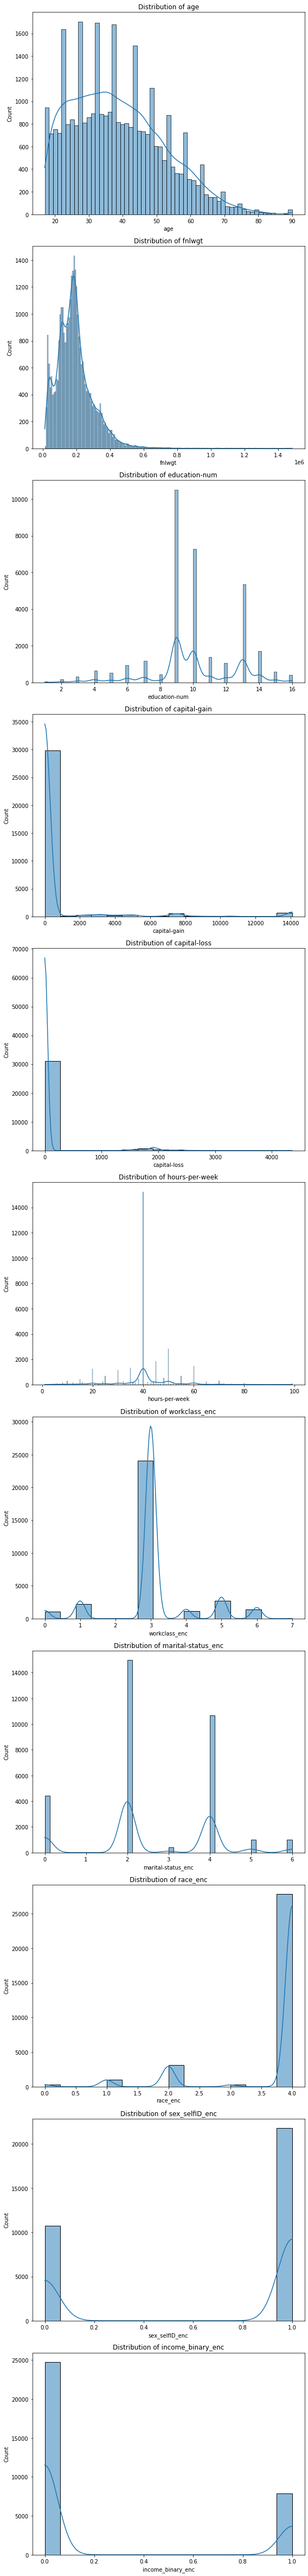

In [16]:
# Set up the figure and axes
fig, axes = plt.subplots(nrows=len(imputed_df.columns), figsize=(8, 6 * len(imputed_df.columns)))

# Loop through each column and plot its distribution
for i, col in enumerate(imputed_df.columns):
    sns.histplot(data=imputed_df, x=col, ax=axes[i], kde=True)  

    # Set plot title
    axes[i].set_title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout()
plt.show()

Then, I want to check more concretely using the statistical formula for skewness which features are heavily skewed and should therefore be winsorized.

In [17]:
# Calculate skewness for each column
skewness = imputed_df.apply(skew)

# Set threshold for skewness
skewness_threshold = 0.55  # Example threshold

# Identify columns for winsorization
columns_to_winsorize = skewness[(skewness > skewness_threshold) | (skewness < -skewness_threshold)].index
columns_to_winsorize

Index(['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'race_enc',
       'sex_selfID_enc', 'income_binary_enc'],
      dtype='object')

From my observations, it looks like 'age', 'fnlwgt', 'capital-gain', and 'capital-loss' are the numerical features we need to winsorize.

In [18]:
# Computing the n-th Percentile of columns

age_99 = np.percentile(imputed_df['age'], 99)
print(age_99)

fnlwgt_99 = np.percentile(imputed_df['fnlwgt'], 99)
print(fnlwgt_99)

capgain_95 = np.percentile(imputed_df['capital-gain'], 95)
print(capgain_95)

caploss_95 = np.percentile(imputed_df['capital-loss'], 95)
print(caploss_95)

74.0
510072.0
5013.0
0.0


It looks like capital-gain and capital-loss are extremely heavily skewed, so I am deciding to drop them from the model entirely to prevent it from affecting the performance of my model.

In [19]:
imputed_df = imputed_df.drop(columns=['capital-gain', 'capital-loss'], axis=0)

In [20]:
imputed_df.head()

,age,fnlwgt,education-num,hours-per-week,workclass_enc,marital-status_enc,race_enc,sex_selfID_enc,income_binary_enc
0,39.0,77516.0,13.0,40.0,6.0,4.0,4.0,1.0,0.0
1,50.0,83311.0,13.0,13.0,5.0,2.0,4.0,1.0,0.0
2,38.0,215646.0,9.0,40.0,3.0,0.0,4.0,1.0,0.0
3,53.0,234721.0,7.0,40.0,3.0,2.0,2.0,1.0,0.0
4,28.0,338409.0,13.0,40.0,3.0,2.0,2.0,0.0,0.0


### B. Winsorizing

In [21]:
# Winsorizing age and fnlwgt
imputed_df['age-win'] = stats.mstats.winsorize(imputed_df['age'], limits=[0.1, 0.1])
imputed_df['fnlwgt-win'] = stats.mstats.winsorize(imputed_df['fnlwgt'], limits=[0.1,0.1])

In [22]:
# Dropping the original age and fnlwgt from the final df
imputed_df = imputed_df.drop(columns=['age', 'fnlwgt'], axis=0)

In [23]:
imputed_df.head(20)

,education-num,hours-per-week,workclass_enc,marital-status_enc,race_enc,sex_selfID_enc,income_binary_enc,age-win,fnlwgt-win
0,13.0,40.0,6.0,4.0,4.0,1.0,0.0,39.0,77516.0
1,13.0,13.0,5.0,2.0,4.0,1.0,0.0,50.0,83311.0
2,9.0,40.0,3.0,0.0,4.0,1.0,0.0,38.0,215646.0
3,7.0,40.0,3.0,2.0,2.0,1.0,0.0,53.0,234721.0
4,13.0,40.0,3.0,2.0,2.0,0.0,0.0,28.0,329054.0
5,14.0,40.0,3.0,2.0,4.0,0.0,0.0,37.0,284582.0
6,5.0,16.0,3.0,3.0,2.0,0.0,0.0,49.0,160187.0
7,9.0,45.0,5.0,2.0,4.0,1.0,1.0,52.0,209642.0
8,14.0,50.0,3.0,4.0,4.0,0.0,1.0,31.0,65716.0
9,13.0,40.0,3.0,2.0,4.0,1.0,1.0,42.0,159449.0


## Addressing Class Imbalance

In this section I want to check for class imbalance in my dataset. Since my goal is to create a model that predicts for income, it would have negative real life implications if my dataset had a heavy class imbalance.

In [24]:
counter = Counter(imputed_df['income_binary_enc'])
print(counter)

Counter({0.0: 24720, 1.0: 7841})


It looks like the "<=50K" class is a majority compared to the ">50K" class, with a rough ratio of 3:1. In order to rectify this, I will use SMOTE to resample the training data.

### A. SMOTE

In [25]:
# Creating features and label
y = imputed_df['income_binary_enc']
X = imputed_df.drop(columns=['income_binary_enc'], axis=0)

In [26]:
# Splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=42)

# Fit and transform the data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Resampled class distribution:", Counter(y_resampled))

Resampled class distribution: Counter({1.0: 19778, 0.0: 19778})


## Part 3: Implement Your Project Plan

<b>Task:</b> Use the rest of this notebook to carry out your project plan. You will:

1. Prepare your data for your model and create features and a label.
2. Fit your model to the training data and evaluate your model.
3. Improve your model by performing model selection and/or feature selection techniques to find best model for your problem.


Add code cells below and populate the notebook with commentary, code, analyses, results, and figures as you see fit.

## MODEL TRAINING, VALIDATION & EVALUATION

I will use 4 different models: Logistic Regression, Decision Tree, GBDT, and Random Forest. In each model, I will attempt to use cross-validation techniques to find the most optimal hyperparameters for each model, which will in turn improve overall model performance.

I will also use precision and recall as evaluation metrics. I decided against using accuracy due to the heavy class imbalance present in my dataset. I also decided to look at both precision and recall rather than focus on just either one because of the versatility of the use-cases for my model. For things like risk assessment in banking, for example, precision is a better metric to use because it would be too much risk for the bank to use recall and thus prioritize a greater quantity of predictions of the “rich/higher income” class. But if we were talking about a social impact business whose goal is to provide help for lower income groups, then recall would be a better evaluation metric.

In addition to precision-recall, I will also use AUC ROC as a separate evaluation metric.

## 1. Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

### A. Creating and Fitting the Model

Note that I decided against doing a GridSearch cross validation of the L1/L2 regularization penalties for my Logistic Regression model because, complying with the rules of agile development, I wanted my LR model to be the baseline of all my models in the sense that I wanted to get a feel of how a simple model would perform. 

In [29]:
# Create the model 
lr_model = LogisticRegression()
lr_model.fit(X_resampled, y_resampled)

LogisticRegression()

In [30]:
# Make predictions on the test data
y_lr_pred = lr_model.predict(X_test)
y_lr_proba = lr_model.predict_proba(X_test)[:, 1]

### B. Evaluation

In [31]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

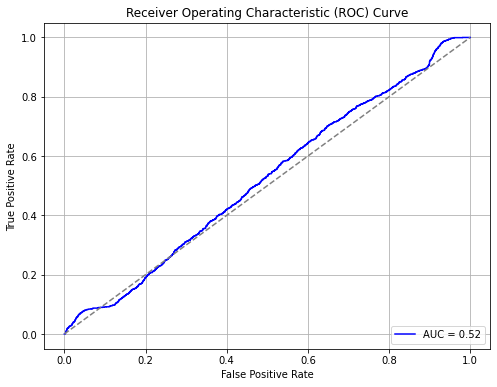

In [32]:
# Calculate AUC-ROC score
lr_auc_roc = roc_auc_score(y_test, y_lr_proba)

# Calculate ROC curve
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, y_lr_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, color='blue', label=f'AUC = {lr_auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [33]:
# Create a confusion matrix
lr_cm = confusion_matrix(y_test, y_lr_pred, labels=[True,False])

# Create a Pandas DataFrame out of the confusion matrix for display
print('Confusion Matrix for the model: ')
pd.DataFrame(lr_cm, columns=['Predicted: <=50K', 'Predicted: >50K'], index = ['Actual: <=50K', 'Actual: >50K'])

Confusion Matrix for the model: 


,Predicted: <=50K,Predicted: >50K
Actual: <=50K,0,1571
Actual: >50K,0,4942


In [34]:
# Calculate precision
lr_pre = precision_score(y_test, y_lr_pred)
print("Precision:", lr_pre)

# Calculate recall
lr_rec = recall_score(y_test, y_lr_pred)
print("Recall:", lr_rec)

Precision: 0.0
Recall: 0.0


/home/codio/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


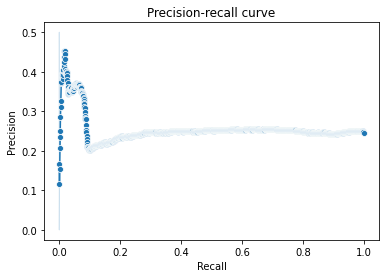

AUC PR Score:  0.2555879580383034


In [35]:
lr_precurve, lr_recurve, lr_threshcurve = precision_recall_curve(y_test, y_lr_proba)

fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x=lr_recurve, y=lr_precurve, marker = 'o')

plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

lr_auc_pr = average_precision_score(y_test, y_lr_proba)
print('AUC PR Score: ', lr_auc_pr)

## 2. Decision Tree

In [36]:
from sklearn.tree import DecisionTreeClassifier

### A. Creating and Fitting the Model

In [37]:
# Create the model 
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_resampled, y_resampled)

DecisionTreeClassifier()

In [38]:
# Define hyperparameters and their possible values
dt_param_grid = {
    'max_depth' : [None, 3, 5, 7, 10, 15, 20],  # Max Depth
    'min_samples_leaf' : [1, 5, 10, 20, 50]  # Min samples leaf
}

# Create a GridSearchCV object
dt_grid = GridSearchCV(dt_classifier, dt_param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the training data
dt_grid_search = dt_grid.fit(X_resampled, y_resampled)

# Print the best parameters and corresponding score
print("Best Parameters:", dt_grid_search.best_params_)
print("Best Score:", dt_grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 10}
Best Score: 0.8508976634523175


In [39]:
# Saving the best params values
dt_max_depth = dt_grid_search.best_params_['max_depth']
dt_min_samples_leaf = dt_grid_search.best_params_['min_samples_leaf']

In [40]:
# Fitting a model with the best params values
dt_model = DecisionTreeClassifier(max_depth=dt_max_depth, min_samples_leaf=dt_min_samples_leaf)
dt_model.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)

In [41]:
# Make predictions on the test data
y_dt_pred = dt_model.predict(X_test)
y_dt_proba = dt_model.predict_proba(X_test)[:, 1]

### B. Evaluation

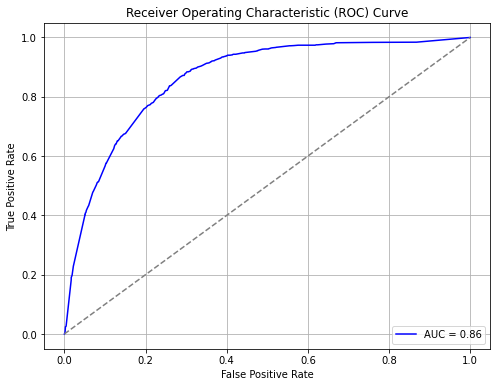

In [42]:
# Calculate AUC-ROC score
dt_auc_roc = roc_auc_score(y_test, y_dt_proba)

# Calculate ROC curve
dt_fpr, dt_tpr, dt_thresholds = roc_curve(y_test, y_dt_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, color='blue', label=f'AUC = {dt_auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [43]:
# Create a confusion matrix
dt_cm = confusion_matrix(y_test, y_dt_pred, labels=[True,False])

# Create a Pandas DataFrame out of the confusion matrix for display
print('Confusion Matrix for the model: ')
pd.DataFrame(dt_cm, columns=['Predicted: <=50K', 'Predicted: >50K'], index = ['Actual: <=50K', 'Actual: >50K'])

Confusion Matrix for the model: 


,Predicted: <=50K,Predicted: >50K
Actual: <=50K,1047,524
Actual: >50K,691,4251


In [44]:
# Calculate precision
dt_pre = precision_score(y_test, y_dt_pred)
print("Precision:", dt_pre)

# Calculate recall
dt_rec = recall_score(y_test, y_dt_pred)
print("Recall:", dt_rec)

Precision: 0.6024165707710012
Recall: 0.6664544875875239


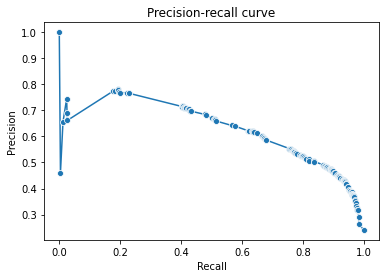

AUC PR Score:  0.6316383149061565


In [45]:
dt_precurve, dt_recurve, dt_threshcurve = precision_recall_curve(y_test, y_dt_proba)

fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x=dt_recurve, y=dt_precurve, marker = 'o')

plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

dt_auc_pr = average_precision_score(y_test, y_dt_proba)
print('AUC PR Score: ', dt_auc_pr)

## 3. Gradient Boosted Decision Tree

In [46]:
from sklearn.ensemble import GradientBoostingClassifier

### A. Creating and Fitting the Model

In [47]:
# Create the model 
gbdt_classifier = GradientBoostingClassifier()
gbdt_classifier.fit(X_resampled, y_resampled)

GradientBoostingClassifier()

In [48]:
# Define hyperparameters and their possible values
gbdt_param_grid = {
    'max_depth' : [3, 5, 7],  # Max Depth
    'n_estimators' : [50, 100]  # N_estimators
}

# Create a GridSearchCV object
gbdt_grid = GridSearchCV(gbdt_classifier, gbdt_param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the training data
gbdt_grid_search = gbdt_grid.fit(X_resampled, y_resampled)

# Print the best parameters and corresponding score
print("Best Parameters:", gbdt_grid_search.best_params_)
print("Best Score:", gbdt_grid_search.best_score_)

Best Parameters: {'max_depth': 5, 'n_estimators': 50}
Best Score: 0.8670523431875263


In [49]:
# Saving the best params values
gbdt_max_depth = gbdt_grid_search.best_params_['max_depth']
gbdt_n_estimators = gbdt_grid_search.best_params_['n_estimators']

In [50]:
# Fitting a model with the best params values
gbdt_model = GradientBoostingClassifier(max_depth=gbdt_max_depth, n_estimators=gbdt_n_estimators)
gbdt_model.fit(X_resampled, y_resampled)

GradientBoostingClassifier(max_depth=5, n_estimators=50)

In [51]:
# Make predictions on the test data
y_gbdt_pred = gbdt_model.predict(X_test)
y_gbdt_proba = gbdt_model.predict_proba(X_test)[:, 1]

### B. Evaluation

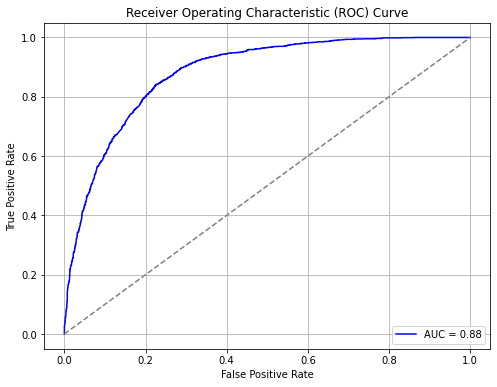

In [52]:
# Calculate AUC-ROC score
gbdt_auc_roc = roc_auc_score(y_test, y_gbdt_proba)

# Calculate ROC curve
gbdt_fpr, gbdt_tpr, gbdt_thresholds = roc_curve(y_test, y_gbdt_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(gbdt_fpr, gbdt_tpr, color='blue', label=f'AUC = {gbdt_auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [53]:
# Create a confusion matrix
gbdt_cm = confusion_matrix(y_test, y_gbdt_pred, labels=[True,False])

# Create a Pandas DataFrame out of the confusion matrix for display
print('Confusion Matrix for the model: ')
pd.DataFrame(gbdt_cm, columns=['Predicted: <=50K', 'Predicted: >50K'], index = ['Actual: <=50K', 'Actual: >50K'])

Confusion Matrix for the model: 


,Predicted: <=50K,Predicted: >50K
Actual: <=50K,1040,531
Actual: >50K,598,4344


In [54]:
# Calculate precision
gbdt_pre = precision_score(y_test, y_gbdt_pred)
print("Precision:", gbdt_pre)

# Calculate recall
gbdt_rec = recall_score(y_test, y_gbdt_pred)
print("Recall:", gbdt_rec)

Precision: 0.6349206349206349
Recall: 0.6619987269255252


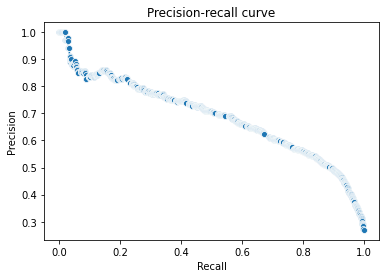

AUC PR Score:  0.6880127130425759


In [55]:
gbdt_precurve, gbdt_recurve, gbdt_threshcurve = precision_recall_curve(y_test, y_gbdt_proba)

fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x=gbdt_recurve, y=gbdt_precurve, marker = 'o')

plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

gbdt_auc_pr = average_precision_score(y_test, y_gbdt_proba)
print('AUC PR Score: ', gbdt_auc_pr)

## 4. Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

### A. Creating and Fitting the Model

In [57]:
# Create the model 
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [58]:
# Define hyperparameters and their possible values
rf_param_grid = {
    'max_depth' : [15, 30, 35],  # Max Depth
    'n_estimators' : [50, 100]  # N_estimators
}

print("Running Grid search...")

# Create a GridSearchCV object
rf_grid = GridSearchCV(rf_classifier, rf_param_grid, cv=5, scoring='accuracy')

# Perform the grid search on the training data
rf_grid_search = rf_grid.fit(X_resampled, y_resampled)

print("Done")

# Print the best parameters and corresponding score
print("Best Parameters:", rf_grid_search.best_params_)
print("Best Score:", rf_grid_search.best_score_)

Running Grid search...
Done
Best Parameters: {'max_depth': 15, 'n_estimators': 100}
Best Score: 0.8686956917956964


In [59]:
# Saving the best params values
rf_max_depth = rf_grid_search.best_params_['max_depth']
rf_n_estimators = gbdt_grid_search.best_params_['n_estimators']

In [60]:
# Fitting a model with the best params values
rf_model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators)
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=15, n_estimators=50)

In [61]:
# Make predictions on the test data
y_rf_pred = rf_model.predict(X_test)
y_rf_proba = rf_model.predict_proba(X_test)[:, 1]

### B. Evaluation

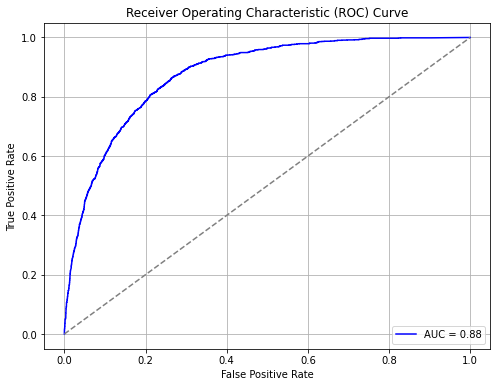

In [62]:
# Calculate AUC-ROC score
rf_auc_roc = roc_auc_score(y_test, y_rf_proba)

# Calculate ROC curve
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_rf_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(rf_fpr, rf_tpr, color='blue', label=f'AUC = {rf_auc_roc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [63]:
# Create a confusion matrix
rf_cm = confusion_matrix(y_test, y_rf_pred, labels=[True,False])

# Create a Pandas DataFrame out of the confusion matrix for display
print('Confusion Matrix for the model: ')
pd.DataFrame(rf_cm, columns=['Predicted: <=50K', 'Predicted: >50K'], index = ['Actual: <=50K', 'Actual: >50K'])

Confusion Matrix for the model: 


,Predicted: <=50K,Predicted: >50K
Actual: <=50K,1035,536
Actual: >50K,600,4342


In [64]:
# Calculate precision
rf_pre = precision_score(y_test, y_rf_pred)
print("Precision:", rf_pre)

# Calculate recall
rf_rec = recall_score(y_test, y_rf_pred)
print("Recall:", rf_rec)

Precision: 0.6330275229357798
Recall: 0.6588160407383832


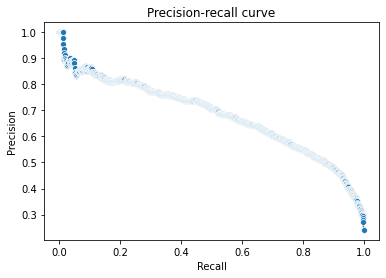

AUC PR Score:  0.6814954866614494


In [65]:
rf_precurve, rf_recurve, rf_threshcurve = precision_recall_curve(y_test, y_rf_proba)

fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x=rf_recurve, y=rf_precurve, marker = 'o')

plt.title("Precision-recall curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

rf_auc_pr = average_precision_score(y_test, y_rf_proba)
print('AUC PR Score: ', rf_auc_pr)

## MODEL SELECTION

In this section, I will visualize the scores for precision-recall, AUC PR, and AUC ROC for all my models and make my analysis on each.

### A. Precision-Recall

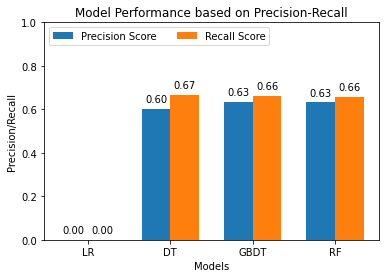

In [66]:
# Visualizing model performance based on PRECISION and RECALL SCORES

pre_results = [lr_pre, dt_pre, gbdt_pre, rf_pre]
rec_results = [lr_rec, dt_rec, gbdt_rec, rf_rec]
labels = ['LR', 'DT', 'GBDT', 'RF']

rg= np.arange(4)
width = 0.35
plt.bar(rg, pre_results, width, label="Precision Score")
plt.bar(rg+width, rec_results, width, label="Recall Score")
plt.xticks(rg + width/2, labels)
plt.xlabel("Models")
plt.ylabel("Precision/Recall")
plt.ylim([0,1])

plt.title('Model Performance based on Precision-Recall')
plt.legend(loc='upper left', ncol=2)

# Annotate bar values on top
for i, value in enumerate(pre_results):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')
for i, value in enumerate(rec_results):
    plt.text(i + width, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

### Analysis
Precision and recall are two metrics that is often described as a trade-off, simply because they are fundamentally at odds with each other; one cannot truly have a high precision without having a low recall and vice versa.

My goal was to get this trade-off between precision and recall to reach a balanced compromise, since, as I have already explained previously, I am not creating this model for a specific use-case and can see good implications for using both precision and recall.

Judging from the plot I've visualized above, my Logistic Regression completely failed to produce both precision and recall. This makes sense, as I mostly treated my LR model as a baseline and did not set any regularization hyperparameters for it. The Decision Tree, GBDT, and Random Forest models were a significant improvement from the LR model with an approximate value of 0.6-0.7 for both precision and recall for each model. This is a good value for both metrics to have, especially since I am prioritizing a balanced trade-off.

Overall, based on Precision-Recall alone, it looks like GBDT and RF are clear winners! 

### B. AUC Precision-Recall

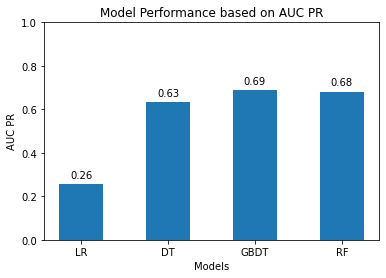

In [67]:
# Visualizing model performance based on AUC PR

auc_pr_results = [lr_auc_pr, dt_auc_pr, gbdt_auc_pr, rf_auc_pr]
labels = ['LR', 'DT', 'GBDT', 'RF']

rg= np.arange(4)
width = 0.5
plt.bar(rg, auc_pr_results, width)
plt.xticks(rg, labels)
plt.xlabel("Models")
plt.ylabel("AUC PR")
plt.ylim([0,1])

plt.title('Model Performance based on AUC PR')

# Annotate bar values on top
for i, value in enumerate(auc_pr_results):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

### Analysis
AUC-PR (Area Under the Precision-Recall Curve) is a metric that is fundamentally similar to Precision-Recall but has slight differences in that it is able to give a more comprehensive view of precision and recall by measuring the overall performance of a model across different threshold settings. It plots precision against recall for various threshold values and calculates the area under this curve. A higher AUC-PR indicates that the model maintains high precision and recall across different levels of classification threshold.

From the plot that I've visualized above, it seems that GBDT has the highest AUC-PR score of 0.69, beating RF by 0.01. Whereas from the previous plot of Precision-Recall, GBDT and RF both had the same scores for precision and recall, we can see from this plot that GBDT had a higher AUC-PR, indicating that the GBDT model achieved a better trade-off between precision and recall overall.

### C. AUC ROC

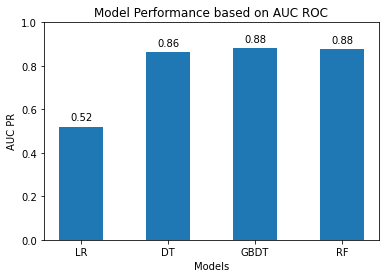

In [69]:
# Visualizing model performance based on AUC ROC

auc_roc_results = [lr_auc_roc, dt_auc_roc, gbdt_auc_roc, rf_auc_roc]
labels = ['LR', 'DT', 'GBDT', 'RF']

rg= np.arange(4)
width = 0.5
plt.bar(rg, auc_roc_results, width)
plt.xticks(rg, labels)
plt.xlabel("Models")
plt.ylabel("AUC PR")
plt.ylim([0,1])

plt.title('Model Performance based on AUC ROC')

# Annotate bar values on top
for i, value in enumerate(auc_roc_results):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', va='bottom')
    
plt.show()

### Analysis
AUC-ROC (Area Under the Receiver Operating Characteristic Curve) is the last metric I decided to use and is different from both precision-recall and AUC PR. The ROC curve plots the true positive rate (recall) against the false positive rate as the classification threshold varies.
AUC-ROC is the area under this ROC curve, which measures the model's ability to distinguish between the positive and negative classes. AUC-ROC is less lenient towards class imbalances.

From the plot I've visualized above, we again see that GBDT and RF produce the highest scores for AUC-ROC. This means GBDT and RF were the two models that were best able to discriminate between the negative and positive classes in this dataset with regards to income.